# Experiment 1: No-fire December set (PWWB + AirNow)

This notebook focuses on running Experiment 1, which uses data from December (no-fire period) combining PWWB and AirNow datasets.

# Data parameters

In [ ]:
# define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 200
frames_per_sample = 5

# date range of data - two weeks of December for this experiment 2024-12-08-00", "2024-12-21-00"
dec_start_date, dec_end_date = "2024-12-01-00", "2025-01-01-00"

# Data ingestion and preprocessing

In [2]:
# python nonsense that allows you to import from sibling directories
import sys
sys.path.append("..")

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dotenv import load_dotenv

# Import the new PWWB implementation and dataset manager
from libs.pwwb import PWWBData
from libs.pwwb.utils.dataset_manager import create_dataset_manager

# Import the AirNow data class
from libs.airnowdata import AirNowData

# Load environment variables (API keys, credentials)
load_dotenv()

# split data
def train_test_split(X, train_size=0.75):
    split_idx = int(X.shape[0] * train_size)
    X_train, X_test = X[:split_idx], X[split_idx:]
    
    return X_train, X_test

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

/home/moh/miniconda3/envs/hysplitrevised/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Create output directory for results
output_dir = "experiment_output"
os.makedirs(output_dir, exist_ok=True)

# Create dataset manager
manager = create_dataset_manager(
    registry_file="experiment1_registry.json",
    cache_dir="data/pwwb_cache/"
)

# List existing datasets
print("Existing datasets:")
try:
    display(manager.list_datasets())
except:
    print("No existing datasets found.")

Error loading registry: Expecting value: line 1 column 1 (char 0)
Existing datasets:
No datasets registered.


""


In [4]:
# Adjust end date for AirNow
dec_end_date_adj = pd.to_datetime(dec_end_date) - pd.Timedelta(hours=1)

# Dataset name and description
dataset_name = "dec2024_MAIC_TROPOMI_N02_METAR_WIND_UV_ONLY"
dataset_desc = "December 2024 - two weeks with MAIAC, TROPOMI NO2, METAR Wind U/V components only"

# ========== 1. Load December PWWB Data ==========
print("\nLoading December PWWB data...")

# Check if dataset already exists in the registry
if manager.get_dataset_info(dataset_name) is not None:
    print(f"Dataset '{dataset_name}' already exists, loading from cache...")
    dec_pwwb = manager.load_dataset(dataset_name, PWWBData)
else:
    print(f"Dataset '{dataset_name}' not found, creating new one...")
    # Create the dataset with the specified channels
    dec_pwwb = manager.create_dataset(
        name=dataset_name,
        description=dataset_desc,
        PWWBData_class=PWWBData,
        start_date=dec_start_date,
        end_date=dec_end_date,
        extent=extent,
        frames_per_sample=frames_per_sample,
        dim=dim,
        include_channels={
            'maiac': True,                     # Include MAIAC AOD
            'tropomi': ['TROPOMI_NO2'],        # Only include NO2 from TROPOMI
            'metar': ['METAR_Wind_U', 'METAR_Wind_V'],  # Only wind components from METAR
            'modis_fire': False,               # Exclude MODIS fire data
            'merra2': False                    # Exclude MERRA2 data
        },
        verbose=True,
        output_dir=output_dir
    )
    # Save the dataset
    dec_pwwb.save_data()

# Get the data and channel info
X_dec_pwwb = dec_pwwb.data
channel_info = dec_pwwb.get_channel_info()
print(f"✓ December PWWB data shape: {X_dec_pwwb.shape}")
print(f"  Channels: {channel_info['channel_names']}")

# ========== 2. Load December AirNow Data ==========
print("\nLoading December AirNow data...")
dec_airnow = AirNowData(
    start_date=dec_start_date,
    end_date=dec_end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../libs/inputs/elevation.npy",
    mask_path="../libs/inputs/mask.npy",
    force_reprocess=False
)
X_dec_airnow = dec_airnow.data
Y_dec = dec_airnow.target_stations
print(f"✓ December AirNow data shape: {X_dec_airnow.shape}")
if Y_dec is not None:
    print(f"  December target stations shape: {Y_dec.shape}")
else:
    print("  No December target stations available")


Loading December PWWB data...
Dataset 'dec2024_MAIC_TROPOMI_N02_METAR_WIND_UV_ONLY' not found in registry.
Dataset 'dec2024_MAIC_TROPOMI_N02_METAR_WIND_UV_ONLY' not found, creating new one...
Using cache prefix: dec2024_MAIC_TROPOMI_N02_METAR_WIND_UV_ONLY_
Initialized PWWBData with 744 hourly timestamps
Date range: 2024-12-01 00:00:00 to 2024-12-31 23:00:00
Channels included: ['maiac', 'tropomi', 'metar']
TROPOMI channels: ['TROPOMI_NO2']
METAR channels: ['METAR_Wind_U', 'METAR_Wind_V']
Processing MAIAC AOD data...
Fetching MAIAC AOD data for 31 unique dates


/home/moh/wildfire/hrrr-smoke-viz/pwwb-experiments/../libs/pwwb/pwwb_data.py:115: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.timestamps = pd.date_range(self.start_date, self.end_date, freq='H')


AOD data shape before resize: (5, 1200, 1200)
AOD data type: int16
AOD data min/max: -28672/1180
Averaged AOD data to shape: (1200, 1200)
Resized AOD data to shape: (200, 200)
Successfully processed AOD data for 2024-12-01
AOD data shape before resize: (4, 1200, 1200)
AOD data type: int16
AOD data min/max: -28672/582
Averaged AOD data to shape: (1200, 1200)
Resized AOD data to shape: (200, 200)
Successfully processed AOD data for 2024-12-02
AOD data shape before resize: (4, 1200, 1200)
AOD data type: int16
AOD data min/max: -28672/637
Averaged AOD data to shape: (1200, 1200)
Resized AOD data to shape: (200, 200)
Successfully processed AOD data for 2024-12-03
AOD data shape before resize: (5, 1200, 1200)
AOD data type: int16
AOD data min/max: -28672/4044
Averaged AOD data to shape: (1200, 1200)
Resized AOD data to shape: (200, 200)
Successfully processed AOD data for 2024-12-04
AOD data shape before resize: (4, 1200, 1200)
AOD data type: int16
AOD data min/max: -28672/752
Averaged AOD d

/home/moh/wildfire/hrrr-smoke-viz/pwwb-experiments/../libs/pwwb/data_sources/metar_data.py:574: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_date_range = pd.date_range(start=start_date_with_margin, end=end_date_with_margin, freq='H')
/home/moh/wildfire/hrrr-smoke-viz/pwwb-experiments/../libs/pwwb/data_sources/metar_data.py:616: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_df['timestep'] = station_df['valid'].dt.ceil('H')
/home/moh/wildfire/hrrr-smoke-viz/pwwb-experiments/../libs/pwwb/data_sources/metar_data.py:616: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_df['timestep'] = station_df['valid'].dt.ceil('H')
/home/moh/wildfire/hrrr-smoke-viz/pwwb-experiments/../libs/pwwb/data_sources/metar_data.py:616: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  st

Computed wind U/V components from speed/direction
U component range: -26.89 to 19.25
V component range: -23.00 to 48.63
Processing 744 timestamps of METAR data
Created METAR data with shape (744, 200, 200, 2)
Final channels: ['METAR_Wind_U', 'METAR_Wind_V']
METAR_Wind_U sample stats: min=0.00, max=9.73, mean=4.93
METAR_Wind_V sample stats: min=2.36, max=5.98, mean=3.96
Saving data to cache: data/pwwb_cache/dec2024_MAIC_TROPOMI_N02_METAR_WIND_UV_ONLY_metar_u_v_data.npy
Final data shape: (740, 5, 200, 200, 4)

Channel Statistics:

Channel 0: MAIAC_AOD
  Min: -28672.000000000007
  Max: -11408.21815610717
  Mean: -22674.333462043887
  Std: 5129.642805682386
  Data coverage: 100.00% (40000/40000 non-zero pixels)

Channel 1: TROPOMI_NO2
  Min: 8.291821094530346e-06
  Max: 0.0005449624637115875
  Mean: 0.00012861194879700214
  Std: 8.197002367478071e-05
  Data coverage: 100.00% (40000/40000 non-zero pixels)

Channel 2: METAR_Wind_U
  Min: 2.816687638038912e-16
  Max: 9.725818625134153
  Mean:

In [5]:
# ========== 3. Create Experiment 1 dataset ==========
print("\nCreating Experiment 1 dataset...")

# Experiment 1: No-fire December set (PWWB + AirNow)
print("  Experiment 1: No-fire December set (PWWB + AirNow)")
X_exp1 = np.concatenate([X_dec_pwwb, X_dec_airnow], axis=-1)
print(f"    Combined shape: {X_exp1.shape}")

# Display the number of channels from each source
pwwb_channels = X_dec_pwwb.shape[4]
airnow_channels = X_dec_airnow.shape[4]
print(f"    PWWB channels: {pwwb_channels}, AirNow channels: {airnow_channels}, Total: {X_exp1.shape[4]}")


Creating Experiment 1 dataset...
  Experiment 1: No-fire December set (PWWB + AirNow)
    Combined shape: (740, 5, 200, 200, 5)
    PWWB channels: 4, AirNow channels: 1, Total: 5


In [6]:
# ========== 4. Train/Test Split for experiment ==========
print("\nCreating train/test splits for experiment...")
# Experiment 1 splits
X_exp1_train, X_exp1_test = train_test_split(X_exp1, train_size=0.75)
Y_dec_train, Y_dec_test = train_test_split(Y_dec, train_size=0.75)
print(f"  Experiment 1: Train={X_exp1_train.shape}, Test={X_exp1_test.shape}")

# ========== 5. Standardize data ==========
print("\nStandardizing data...")

# Experiment 1 standardization
X_exp1_train_scaled, X_exp1_test_scaled = std_scale(X_exp1_train, X_exp1_test)
print(f"  Experiment 1: Scaled train={X_exp1_train_scaled.shape}, test={X_exp1_test_scaled.shape}")


Creating train/test splits for experiment...
  Experiment 1: Train=(555, 5, 200, 200, 5), Test=(185, 5, 200, 200, 5)

Standardizing data...
  Experiment 1: Scaled train=(555, 5, 200, 200, 5), test=(185, 5, 200, 200, 5)


In [7]:
# ========== 6. Save prepared datasets ==========
print("\nSaving prepared dataset...")

# Create directory for experiment
exp_dir = os.path.join(output_dir, "experiment1")
os.makedirs(exp_dir, exist_ok=True)

# Save Experiment 1 data
np.save(os.path.join(exp_dir, "X_train.npy"), X_exp1_train_scaled)
np.save(os.path.join(exp_dir, "X_test.npy"), X_exp1_test_scaled)
np.save(os.path.join(exp_dir, "y_train.npy"), Y_dec_train)
np.save(os.path.join(exp_dir, "y_test.npy"), Y_dec_test)

# Save metadata
metadata = {
    "date_range": f"{dec_start_date} to {dec_end_date}",
    "extent": extent,
    "dim": dim,
    "frames_per_sample": frames_per_sample,
    "pwwb_channels": channel_info['channel_names'],
    "airnow_channels": ["AirNow_PM25"]
}

with open(os.path.join(exp_dir, "metadata.json"), "w") as f:
    import json
    json.dump(metadata, f, indent=2)

print("\n✓ Dataset prepared and saved!")


Saving prepared dataset...

✓ Dataset prepared and saved!


# Data visualization

Visualizing data...


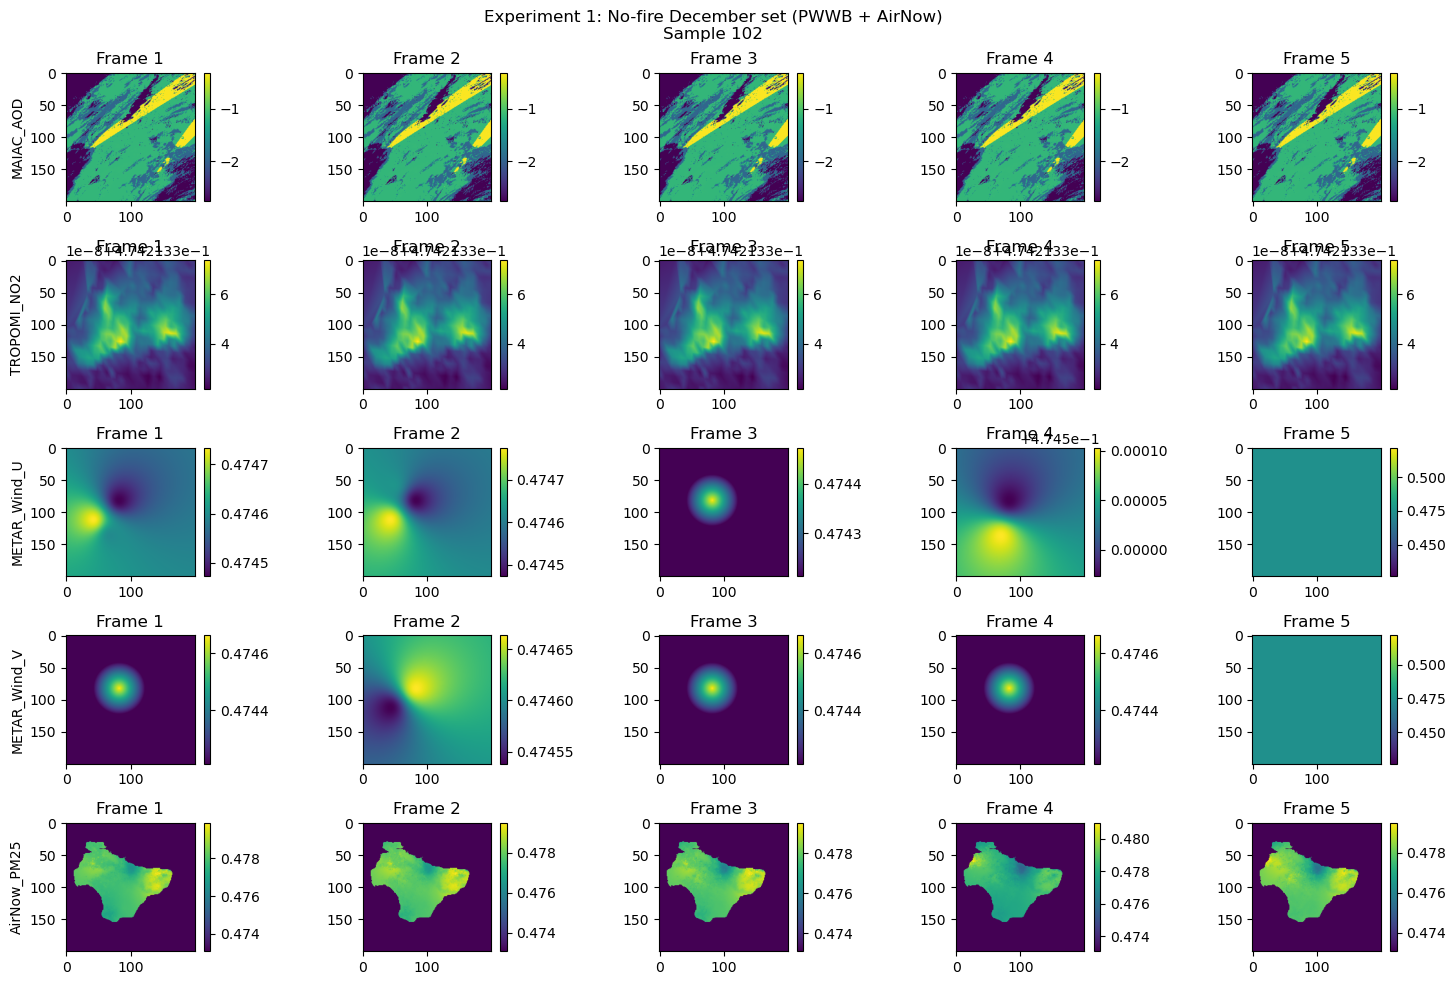

Target values: [14.4 39.9  9.  42.8 41.4 28.7 25.8 10.  43.9 45.9 44.7 35.5  3.1 13.7
 33.2]


In [8]:
# Function to visualize data from experiment
def visualize_experiment_data(X, y, channel_names=None, sample_idx=None):
    """Visualize data from the experiment"""
    # Get a random sample if none provided
    if sample_idx is None:
        np.random.seed(42)
        sample_idx = np.random.choice(range(len(X)), size=1)[0]
    
    # Get channel information
    n_channels = X.shape[4]
    n_frames = X.shape[1]
    
    # Use provided channel names or create default ones
    if channel_names is None or len(channel_names) != n_channels:
        channel_names = [f"Channel {i}" for i in range(n_channels)]
    
    # Create figure
    fig, axes = plt.subplots(n_channels, n_frames, figsize=(3*n_frames, 2*n_channels))
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each channel and frame
    for c in range(n_channels):
        for f in range(n_frames):
            ax = axes[c, f]
            im = ax.imshow(X[sample_idx, f, :, :, c])
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            if f == 0:
                ax.set_ylabel(channel_names[c])
            ax.set_title(f"Frame {f+1}")
    
    # Set title
    plt.suptitle(f"Experiment 1: No-fire December set (PWWB + AirNow)\nSample {sample_idx}")
    plt.tight_layout()
    plt.show()
    
    # Print target values
    if y is not None:
        print(f"Target values: {y[sample_idx]}")

# Create combined channel names list
all_channel_names = channel_info['channel_names'] + ["AirNow_PM25"]

# Visualize a sample from the experiment
print("Visualizing data...")
visualize_experiment_data(X_exp1_train_scaled, Y_dec_train, channel_names=all_channel_names)

# Model

In [9]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

2025-05-20 20:44:33.988611: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 20:44:34.318068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-20 20:44:35.725111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



==== Running Experiment 1: No-fire December set (PWWB + AirNow) ====
Training data shape: (555, 5, 200, 200, 5)
Target data shape: (555, 15)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 200, 200,    │        10,860 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 200, 200,    │        48,720 │
│                                 │ 30)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 200, 200,    │        12,165 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 200, 200, 1) │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │     3,000,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,072,166 (11.72 MB)

 Trainable params: 3,072,166 (11.72 MB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 446ms/step - loss: 10.2661 - val_loss: 15.3943
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 419ms/step - loss: 9.2739 - val_loss: 15.4845
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 49s 439ms/step - loss: 9.5171 - val_loss: 14.6560
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 416ms/step - loss: 9.1002 - val_loss: 13.9399
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 420ms/step - loss: 7.6781 - val_loss: 13.4300
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 49s 439ms/step - loss: 6.8911 - val_loss: 12.6745
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 416ms/step - loss: 6.9540 - val_loss: 13.6868
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 435ms/step - loss: 6.5758 - val_loss: 14.1433
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 417ms/step - loss: 6.5119 - val_loss: 13.6473
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 49s 438ms/step - loss: 6.3420 - val_loss: 13.0037
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 417ms/step - loss: 6.37

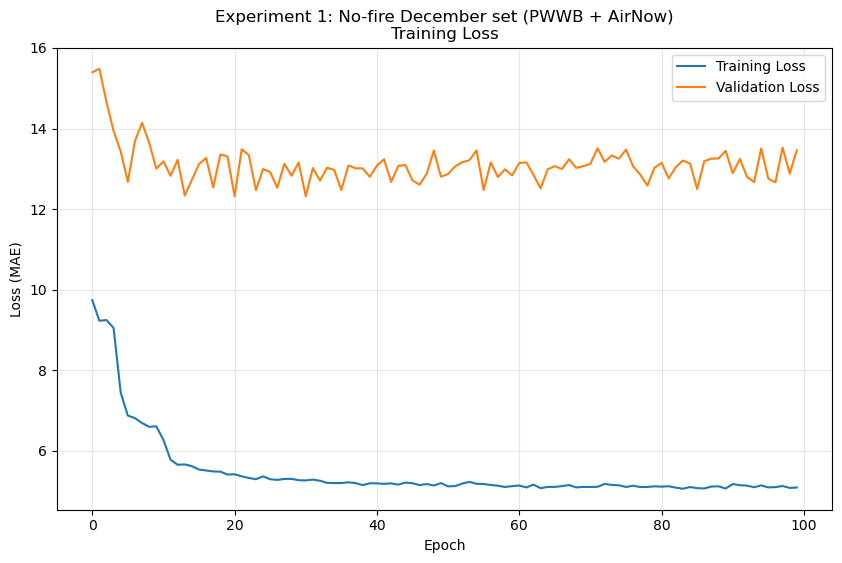

In [10]:
# Run Experiment 1: No-fire December set (PWWB + AirNow)
print("\n==== Running Experiment 1: No-fire December set (PWWB + AirNow) ====")
print(f"Training data shape: {X_exp1_train_scaled.shape}")
print(f"Target data shape: {Y_dec_train.shape}")

# Build model
seq = Sequential()

seq.add(
    InputLayer(shape=X_exp1_train_scaled.shape[1:])
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())
seq.add(Dense(Y_dec_train.shape[1], activation='relu'))

# Compile model
seq.compile(loss='mean_absolute_error', optimizer='adam')

# Print model summary
seq.summary()

# Train model
print(f"\nTraining model...")
epochs = 100  # Reduced epochs for faster testing
batch_size = 4
history = seq.fit(
    X_exp1_train_scaled, Y_dec_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

# Evaluate model
print(f"\nEvaluating model...")
test_loss = seq.evaluate(X_exp1_test_scaled, Y_dec_test, verbose=0)
print(f"Test MAE: {test_loss:.4f}")

# Make predictions
y_pred = seq.predict(X_exp1_test_scaled, verbose=0)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(Y_dec_test, y_pred)
rmse = np.sqrt(mean_squared_error(Y_dec_test, y_pred))
r2 = r2_score(Y_dec_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
plt.title('Experiment 1: No-fire December set (PWWB + AirNow)\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

# Save results
results_dir = os.path.join(output_dir, "experiment1", "results")
os.makedirs(results_dir, exist_ok=True)

np.save(os.path.join(results_dir, "y_pred.npy"), y_pred)
seq.save(os.path.join(results_dir, "model.h5"))

exp1_results = {
    'model': seq,
    'history': history,
    'loss': test_loss,
    'mae': mae,
    'rmse': rmse,
    'r2': r2,
    'y_pred': y_pred,
    'y_test': Y_dec_test
}

# Evaluate

In [11]:
print(f"\nDetailed analysis for Experiment 1:")
X_test = X_exp1_test_scaled
y_test = Y_dec_test
y_pred = exp1_results['y_pred']
model = exp1_results['model']
description = "No-fire December set (PWWB + AirNow), two weeks"

print(f"Analyzing Experiment 1: {description}")


Detailed analysis for Experiment 1:
Analyzing Experiment 1: No-fire December set (PWWB + AirNow), two weeks



1. Plotting prediction comparison...


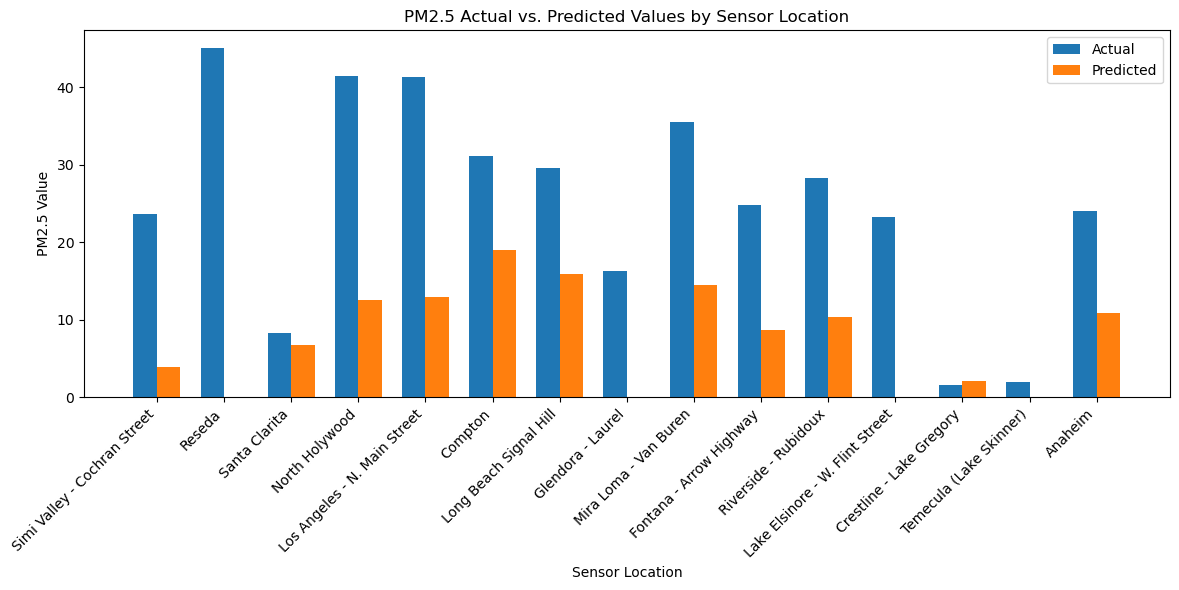


2. Plotting scatter comparison...


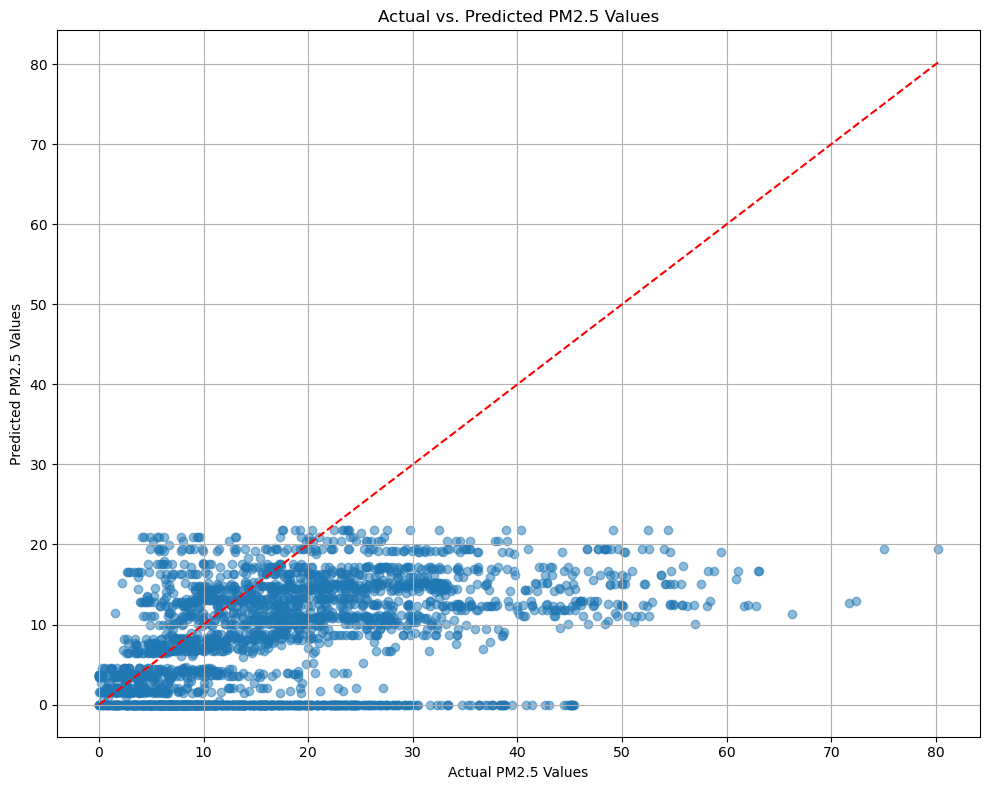


3. Plotting error by sensor...


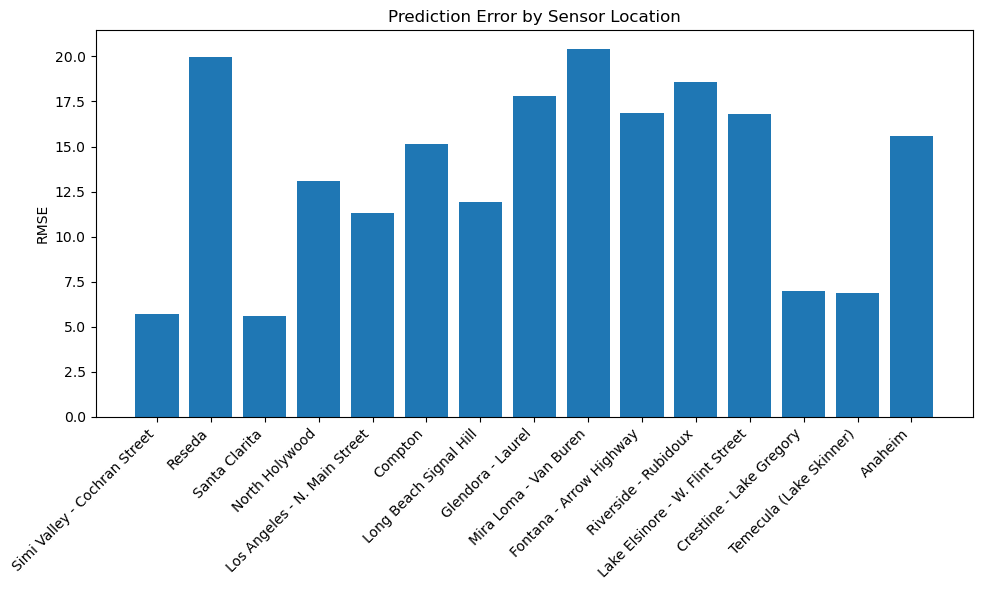


4. Plotting time series comparison...


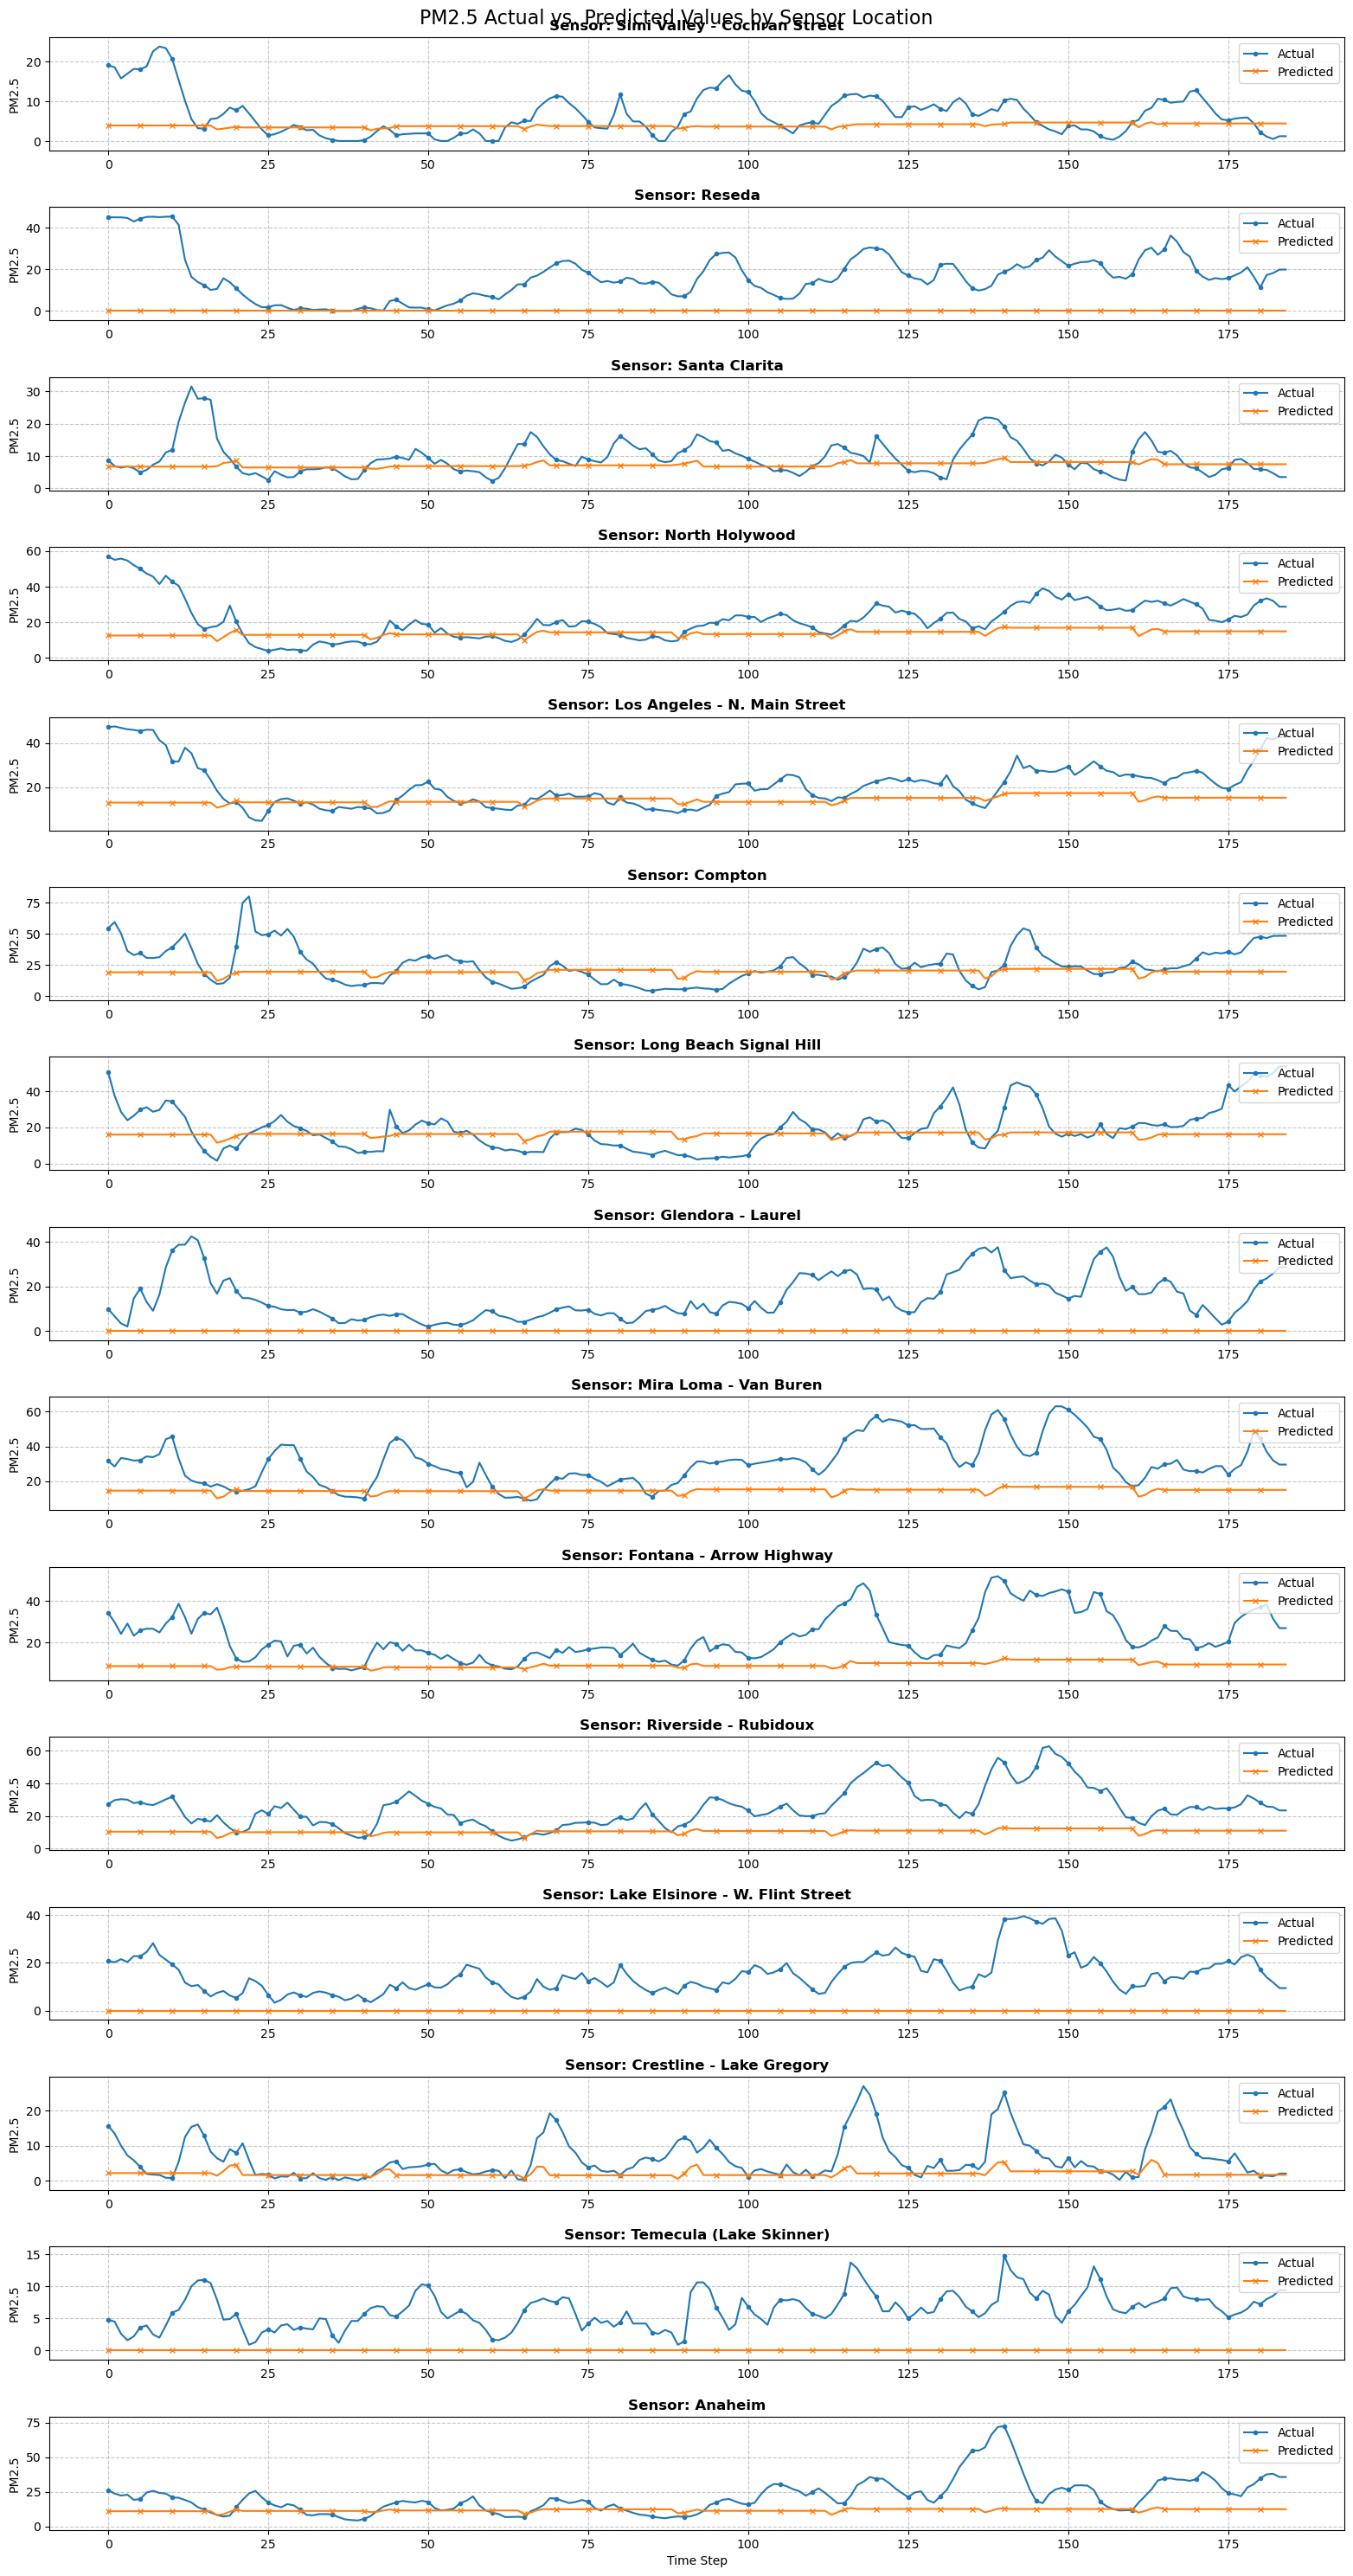


5. Plotting time series with shifted predictions...


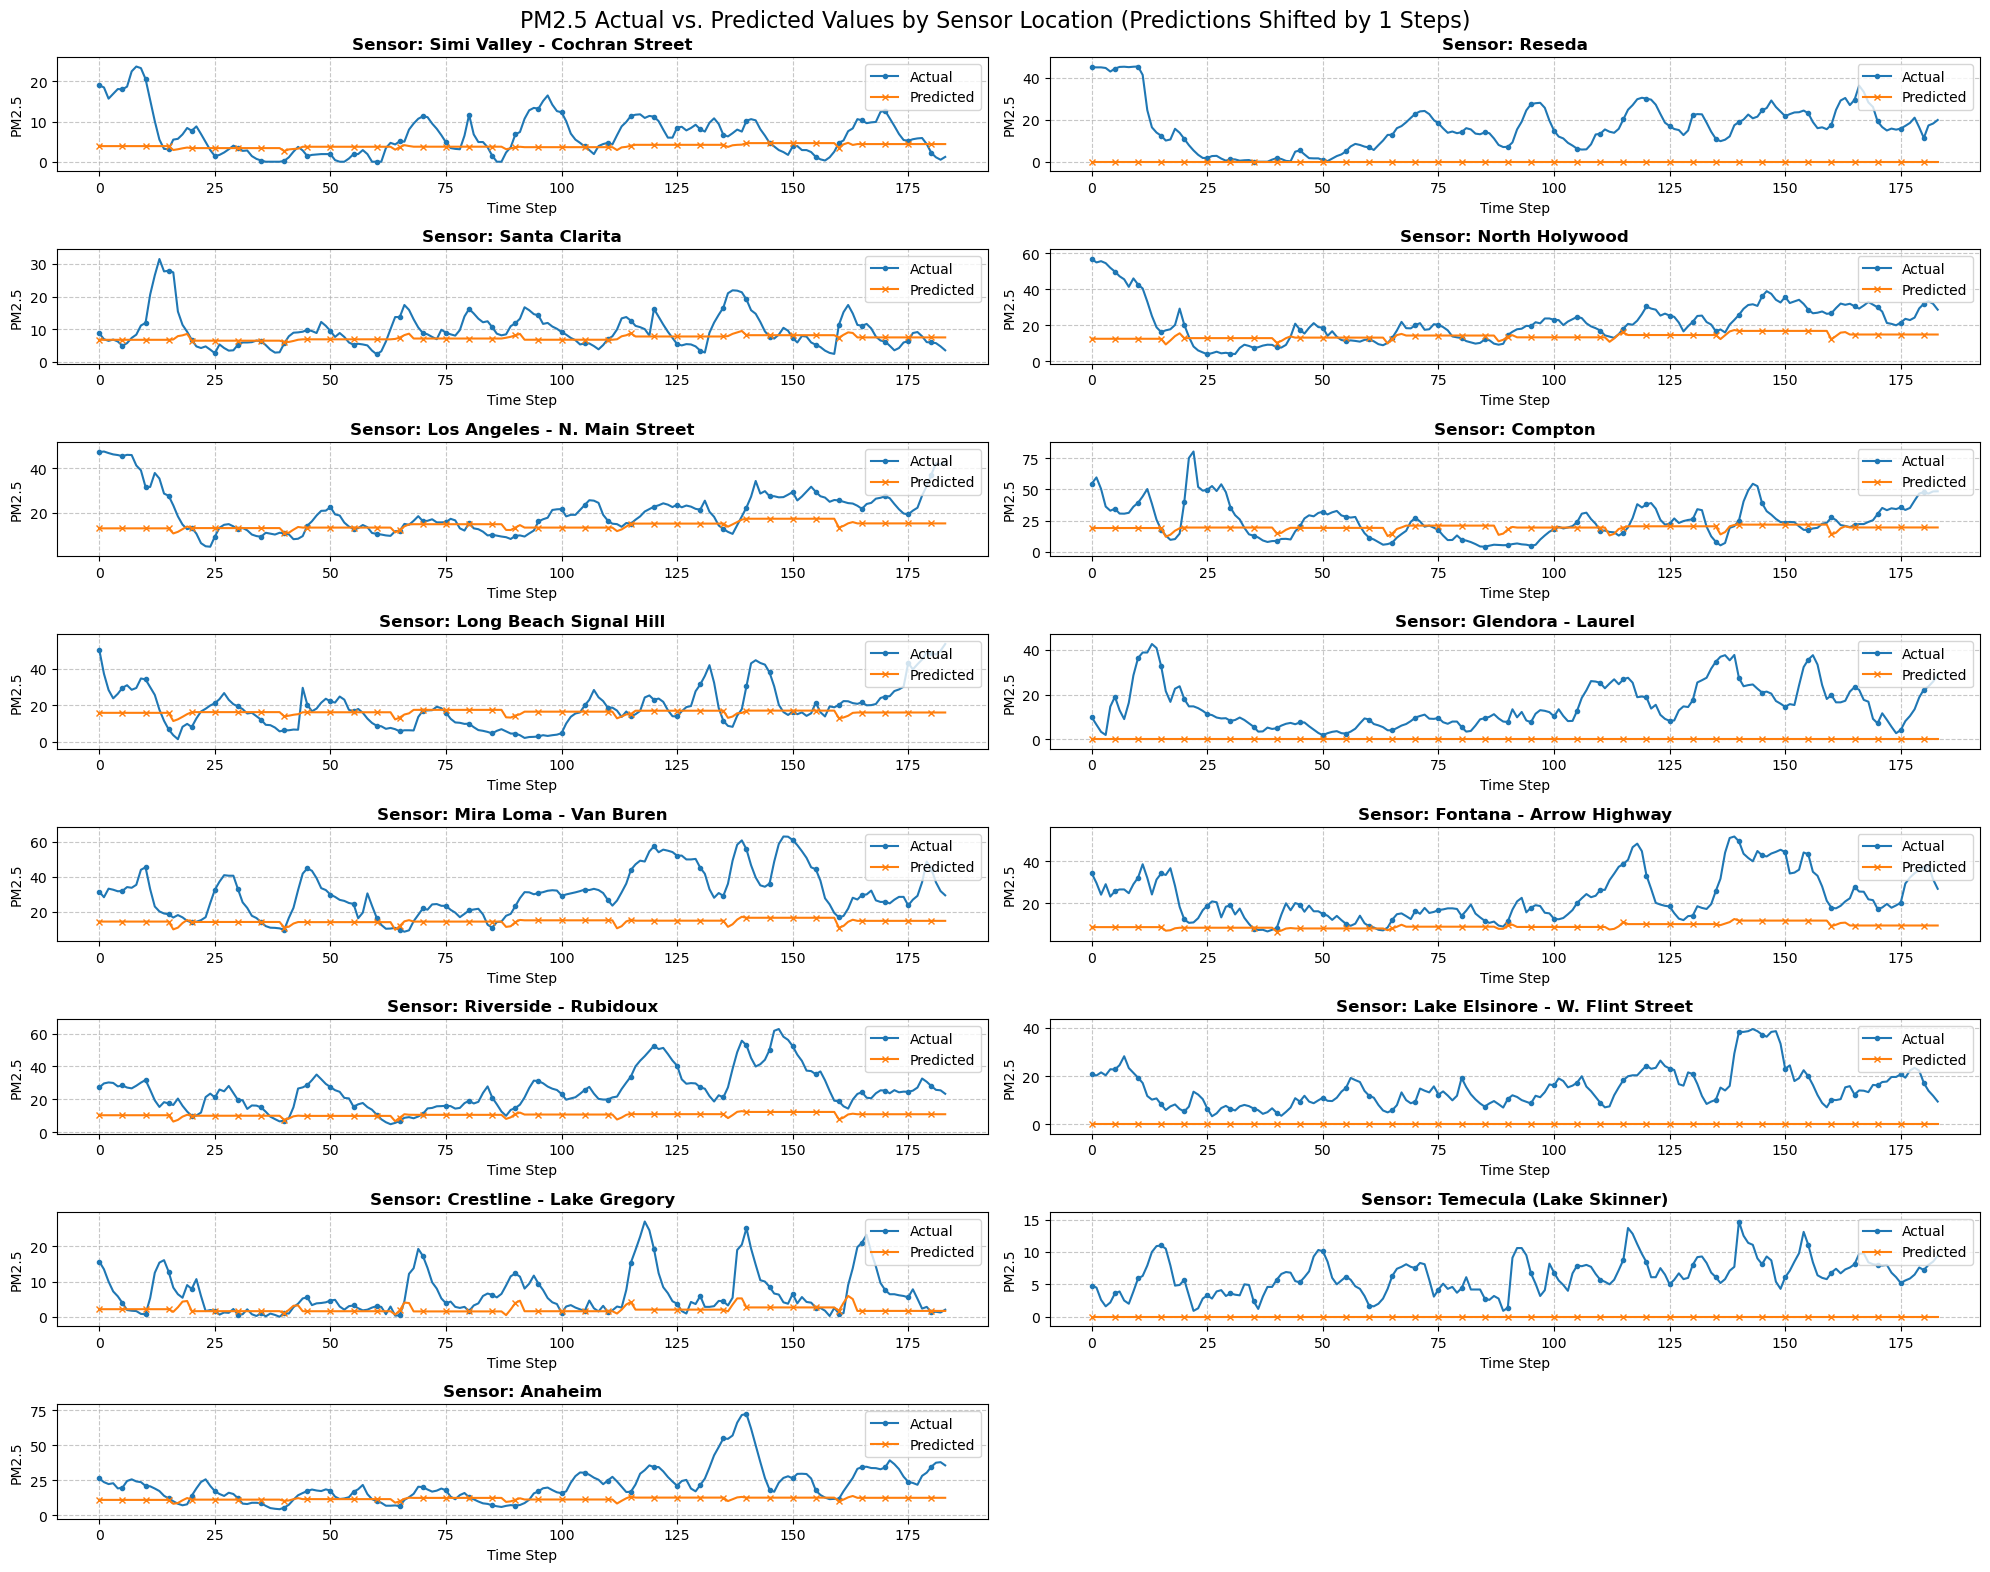


6. Printing metrics...
RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 14.42
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 82.89%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 25.91
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 85.92%

Frame 2 (Hour 2) All Locations - Raw RMSE: 24.65
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 86.81%

Frame 3 (Hour 3) All Locations - Raw RMSE: 23.07
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 87.42%

Frame 4 (Hour 4) All Locations - Raw RMSE: 21.81
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 87.23%

Frame 5 (Hour 5) All Locations - Raw RMSE: 21.05
Frame 5 (Hour 5) All Locations - RMSE Percent Error of Mean: 84.87%

Frame 6 (Hour 6) All Locations - Raw RMSE: 21.54
Frame 6 (Hour 6) All Loc

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Union, Tuple
from skimage.metrics import mean_squared_error

def rmse(y_pred: np.ndarray, y_test: np.ndarray) -> float:
    """Calculate Root Mean Square Error between predictions and ground truth."""
    return np.sqrt(mean_squared_error(y_pred, y_test))

def nrmse(y_pred: np.ndarray, y_test: np.ndarray) -> float:
    """Calculate Normalized Root Mean Square Error between predictions and ground truth."""
    return rmse(y_pred, y_test) / np.mean(y_test) * 100

def plot_prediction_comparison(
    y_pred: np.ndarray,
    y_test: np.ndarray,
    sensor_names: List[str],
    sample_idx: int = 0,
    figsize: Tuple[int, int] = (12, 6)
) -> None:
    """
    Create a bar chart comparing predicted vs actual values for each sensor.
    
    Args:
        y_pred: Array of predicted values
        y_test: Array of ground truth values
        sensor_names: List of sensor location names
        sample_idx: Index of sample to plot
        figsize: Figure size as (width, height)
    """
    fig, ax = plt.subplots(figsize=figsize)
    x = np.arange(len(sensor_names))
    width = 0.35

    true_vals = y_test[sample_idx]
    pred_vals = y_pred[sample_idx]

    rects1 = ax.bar(x - width/2, true_vals, width, label='Actual')
    rects2 = ax.bar(x + width/2, pred_vals, width, label='Predicted')

    ax.set_title('PM2.5 Actual vs. Predicted Values by Sensor Location')
    ax.set_ylabel('PM2.5 Value')
    ax.set_xlabel('Sensor Location')
    ax.set_xticks(x)
    ax.set_xticklabels(sensor_names, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_scatter_comparison(
    y_pred: np.ndarray,
    y_test: np.ndarray,
    figsize: Tuple[int, int] = (10, 8)
) -> None:
    """
    Create a scatter plot of predicted vs actual values.
    
    Args:
        y_pred: Array of predicted values
        y_test: Array of ground truth values
        figsize: Figure size as (width, height)
    """
    plt.figure(figsize=figsize)
    plt.scatter(y_test.flatten(), y_pred.flatten(), alpha=0.5)
    plt.plot([0, np.max(y_test)], [0, np.max(y_test)], 'r--')  # Perfect prediction line
    plt.xlabel('Actual PM2.5 Values')
    plt.ylabel('Predicted PM2.5 Values')
    plt.title('Actual vs. Predicted PM2.5 Values')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_error_by_sensor(
    y_pred: np.ndarray,
    y_test: np.ndarray,
    sensor_names: List[str],
    figsize: Tuple[int, int] = (10, 6)
) -> None:
    """
    Create a bar chart of RMSE errors by sensor location.
    
    Args:
        y_pred: Array of predicted values
        y_test: Array of ground truth values
        sensor_names: List of sensor location names
        figsize: Figure size as (width, height)
    """
    error_by_sensor = []
    for i in range(len(sensor_names)):
        error = rmse(y_pred[:, i], y_test[:, i])
        error_by_sensor.append(error)

    plt.figure(figsize=figsize)
    plt.bar(sensor_names, error_by_sensor)
    plt.ylabel('RMSE')
    plt.title('Prediction Error by Sensor Location')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_time_series_comparison(
    y_pred: np.ndarray,
    y_test: np.ndarray,
    sensor_names: List[str],
    figsize: Tuple[int, int] = (16, 24),  # Increased height
    shift_pred: Optional[int] = None,
    remove_outliers: Optional[Tuple[int, int]] = None,
    subplot_height: float = 2.0  # Height per subplot in inches
) -> None:
    """
    Create time series plots comparing predicted vs actual values for each sensor.
    
    Args:
        y_pred: Array of predicted values
        y_test: Array of ground truth values
        sensor_names: List of sensor location names
        figsize: Figure size as (width, height)
        shift_pred: Number of time steps to shift predictions (e.g. 1 for left shift)
        remove_outliers: Tuple of (start_idx, end_idx) to set predictions to 0 in that range
        subplot_height: Height per subplot in inches for better spacing
    """
    # Calculate dynamic figure height based on number of sensors and desired subplot height
    num_sensors = len(sensor_names)
    fig_height = num_sensors * subplot_height
    plt.figure(figsize=(figsize[0], fig_height))
    
    # Handle optional modifications to predictions
    y_pred_plot = y_pred.copy()
    if remove_outliers is not None:
        start_idx, end_idx = remove_outliers
        y_pred_plot[start_idx:end_idx] = 0.0
    if shift_pred is not None:
        y_pred_plot = y_pred_plot[shift_pred:]
        y_test_plot = y_test[:-shift_pred] if shift_pred > 0 else y_test.copy()
    else:
        y_test_plot = y_test.copy()

    for i, sensor in enumerate(sensor_names):
        ax = plt.subplot(num_sensors, 1, i + 1)
        
        # Plot data with distinct colors and markers for better visibility
        plt.plot(y_test_plot[:, i], label='Actual', marker='o', markersize=3, 
                 color='#1f77b4', linewidth=1.5, markevery=5)
        plt.plot(y_pred_plot[:, i], label='Predicted', marker='x', markersize=4,
                 color='#ff7f0e', linewidth=1.5, markevery=5)
        
        # Add grid with light color for better readability
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Improve title and labels
        plt.title(f'Sensor: {sensor}', fontsize=12, fontweight='bold')
        plt.ylabel('PM2.5', fontsize=10)
        
        # Only add x-label for the bottom subplot
        if i == num_sensors - 1:
            plt.xlabel('Time Step', fontsize=10)
        
        # Add legend for each subplot with better placement
        plt.legend(loc='upper right')
        
        # Set y limits with a bit of padding for better visualization
        y_max = max(np.max(y_test_plot[:, i]), np.max(y_pred_plot[:, i]))
        y_min = min(np.min(y_test_plot[:, i]), np.min(y_pred_plot[:, i]))
        padding = (y_max - y_min) * 0.1
        plt.ylim(y_min - padding, y_max + padding)
    
    plt.tight_layout(pad=2.0)  # Increase padding between subplots
    plt.subplots_adjust(hspace=0.5)  # Add more space between subplots
    
    # Add overall title
    title_text = 'PM2.5 Actual vs. Predicted Values by Sensor Location'
    if shift_pred is not None:
        title_text += f' (Predictions Shifted by {shift_pred} Steps)'
    plt.suptitle(title_text, fontsize=16, y=0.995)
    
    plt.show()

def plot_time_series_grid(
    y_pred: np.ndarray,
    y_test: np.ndarray,
    sensor_names: List[str],
    figsize: Tuple[int, int] = (20, 16),
    shift_pred: Optional[int] = None,
    remove_outliers: Optional[Tuple[int, int]] = None,
    ncols: int = 2  # Number of columns in the grid
) -> None:
    """
    Create time series plots in a grid layout for better visualization.
    
    Args:
        y_pred: Array of predicted values
        y_test: Array of ground truth values
        sensor_names: List of sensor location names
        figsize: Figure size as (width, height)
        shift_pred: Number of time steps to shift predictions
        remove_outliers: Tuple of (start_idx, end_idx) to set predictions to 0
        ncols: Number of columns in the grid
    """
    # Handle optional modifications to predictions
    y_pred_plot = y_pred.copy()
    if remove_outliers is not None:
        start_idx, end_idx = remove_outliers
        y_pred_plot[start_idx:end_idx] = 0.0
    if shift_pred is not None:
        y_pred_plot = y_pred_plot[shift_pred:]
        y_test_plot = y_test[:-shift_pred] if shift_pred > 0 else y_test.copy()
    else:
        y_test_plot = y_test.copy()
    
    # Calculate required rows
    num_sensors = len(sensor_names)
    nrows = int(np.ceil(num_sensors / ncols))
    
    # Create figure
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    # Flatten axes array for easier indexing
    if nrows == 1 and ncols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Plot each sensor
    for i, sensor in enumerate(sensor_names):
        if i < len(axes):
            ax = axes[i]
            # Plot data
            ax.plot(y_test_plot[:, i], label='Actual', marker='o', markersize=3, 
                   color='#1f77b4', linewidth=1.5, markevery=5)
            ax.plot(y_pred_plot[:, i], label='Predicted', marker='x', markersize=4,
                   color='#ff7f0e', linewidth=1.5, markevery=5)
            
            # Add grid and titles
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_title(f'Sensor: {sensor}', fontsize=12, fontweight='bold')
            ax.set_ylabel('PM2.5', fontsize=10)
            ax.set_xlabel('Time Step', fontsize=10)
            ax.legend(loc='upper right')
            
            # Set y limits with padding
            y_max = max(np.max(y_test_plot[:, i]), np.max(y_pred_plot[:, i]))
            y_min = min(np.min(y_test_plot[:, i]), np.min(y_pred_plot[:, i]))
            padding = (y_max - y_min) * 0.1
            ax.set_ylim(y_min - padding, y_max + padding)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    # Add overall title
    title_text = 'PM2.5 Actual vs. Predicted Values by Sensor Location'
    if shift_pred is not None:
        title_text += f' (Predictions Shifted by {shift_pred} Steps)'
    plt.suptitle(title_text, fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for suptitle
    plt.show()

def plot_input_frames(
    X: np.ndarray,
    sample_idx: int = 0,
    n_frames: int = 5,
    n_channels: int = 2,
    channel_names: Optional[List[str]] = None,
    figsize: Tuple[int, int] = (15, 6)
) -> None:
    """
    Plot input frames for a given sample.
    
    Args:
        X: Input data array
        sample_idx: Index of sample to plot
        n_frames: Number of frames to plot
        n_channels: Number of channels in the data
        channel_names: Names of the channels
        figsize: Figure size as (width, height)
    """
    if channel_names is None:
        channel_names = [f'Channel {i}' for i in range(n_channels)]
    
    fig, axes = plt.subplots(n_channels, n_frames, figsize=figsize)
    
    for channel in range(n_channels):
        for frame in range(n_frames):
            ax = axes[channel, frame]
            im = ax.imshow(np.squeeze(X[sample_idx, frame, :, :, channel]), cmap='viridis')
            ax.set_title(f"{channel_names[channel]} Frame {frame + 1}")
            ax.axis("off")
    
    plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
    plt.suptitle(f'Input data for sample {sample_idx}')
    plt.tight_layout()
    plt.show()

def print_metrics(
    y_pred: np.ndarray,
    y_test: np.ndarray,
    sensor_names: List[str]
) -> None:
    """
    Print RMSE metrics for predictions.
    
    Args:
        y_pred: Array of predicted values
        y_test: Array of ground truth values
        sensor_names: List of sensor location names
    """
    print("RESULTS")
    print("---------------------------------------------------------------------------")
    print(f"All Days All Locations - y_pred vs y_test Raw RMSE: {rmse(y_pred, y_test):.2f}")
    print(f"All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: {nrmse(y_pred, y_test):.2f}%\n")

    print("RESULTS BY FRAME")
    print("---------------------------------------------------------------------------")
    for i in range(y_pred.shape[0]):
        print(f"Frame {i+1} (Hour {i+1}) All Locations - Raw RMSE: {rmse(y_pred[i,:], y_test[i,:]):.2f}")
        print(f"Frame {i+1} (Hour {i+1}) All Locations - RMSE Percent Error of Mean: {nrmse(y_pred[i,:], y_test[i,:]):.2f}%\n")

    print("RESULTS BY SENSOR LOCATION")
    print("---------------------------------------------------------------------------")
    for i, loc in enumerate(sensor_names):
        print(f"All Days - {loc} Raw RMSE: {rmse(y_pred[:,i], y_test[:,i]):.2f}")
        print(f"All Days - {loc} RMSE Percent Error of Mean: {nrmse(y_pred[:,i], y_test[:,i]):.2f}%\n")

# Sensor names (use AirNow sensor names if available)
if hasattr(dec_airnow, 'sensor_names') and dec_airnow.sensor_names is not None:
    sensor_names = dec_airnow.sensor_names
else:
    sensor_names = [
        "North Holywood", 
        "Los Angeles - N. Main Street", 
        "Compton",
        "Crestline - Lake Gregory",
        "Fontana - Arrow Highway",
        "Glendora - Laurel",
        "Lake Elsinore - W. Flint Street",
        "Long Beach Signal Hill",
        "Mira Loma - Van Buren",
        "Reseda",
        "Riverside - Rubidoux",
        "Santa Clarita",
        "Simi Valley - Cochran Street",
        "Temecula (Lake Skinner)"
    ]

print("\n1. Plotting prediction comparison...")
plot_prediction_comparison(y_pred, y_test, sensor_names, sample_idx=8)

print("\n2. Plotting scatter comparison...")
plot_scatter_comparison(y_pred, y_test)

print("\n3. Plotting error by sensor...")
plot_error_by_sensor(y_pred, y_test, sensor_names)

print("\n4. Plotting time series comparison...")
# Using the improved vertical layout with better spacing
plot_time_series_comparison(y_pred, y_test, sensor_names)
    
print("\n5. Plotting time series with shifted predictions...")
# Alternative: Using the grid layout for better visualization
plot_time_series_grid(y_pred, y_test, sensor_names, shift_pred=1, ncols=2)

print("\n6. Printing metrics...")
print_metrics(y_pred, y_test, sensor_names)

In [ ]:
# Save experiment comparison
with open(os.path.join(output_dir, 'experiment1_results.txt'), 'w') as f:
    f.write("==== Experiment 1 Results ====\n")
    f.write(f"Experiment 1 (No-fire December, two weeks): MAE = {exp1_results['mae']:.4f}, RMSE = {exp1_results['rmse']:.4f}, R² = {exp1_results['r2']:.4f}\n")
    f.write(f"\nAnalysis completed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\nExperiment 1 complete!")


Experiment 1 complete!


: 